<a href="https://colab.research.google.com/github/Jakub-MFP/My_FIRE_Project/blob/master/portfolio_management/Kelly_Criterion_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
#Import libraries
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
import cufflinks as cf
from pylab import plt

np.random.seed(1) # For reproducibility
plt.style.use('seaborn') 
%matplotlib inline
#Coin flip variable set up
p = 0.55 #Fixes the probability for heads.
f = p - (1-p) #Calculates the optimal fraction according to the Kelly criterion.
f

0.10000000000000009

In [55]:
# Preparing our simulation of coin flips with variables
I = 50 #The number of series to be simulated.
n = 100 #The number of trials per series.

def run_simulation(f):
    c = np.zeros((n, I)) #Instantiates an ndarray object to store the simulation results.
    c[0] = 100 #Initializes the starting capital with 100.
    for i in range(I): #Outer loop for the series simulations.
        for t in range(1,n): #Inner loop for the series itself.
            o = np.random.binomial(1, p) #Simulates the tossing of a coin.
            if o > 0: #If 1, i.e., heads …
                c[t, i] = (1+f) * c[t-1,i] #… then add the win to the capital.
            else: #If 0, i.e., tails …
                c[t, i] = (1-f) * c[t-1,i] #… then subtract the loss from the capital.
    return c

c_1 = run_simulation(f) #Runs the simulation.
c_1.round(2) #Looking at a simulation

array([[100.  , 100.  , 100.  , ..., 100.  , 100.  , 100.  ],
       [110.  ,  90.  ,  90.  , ...,  90.  , 110.  , 110.  ],
       [ 99.  ,  99.  ,  81.  , ...,  81.  , 121.  , 121.  ],
       ...,
       [185.2 ,  45.46,  20.37, ...,  67.9 ,  82.99, 413.27],
       [166.68,  50.  ,  22.41, ...,  74.69,  74.69, 371.94],
       [183.34,  55.  ,  24.65, ...,  82.16,  67.22, 334.75]])

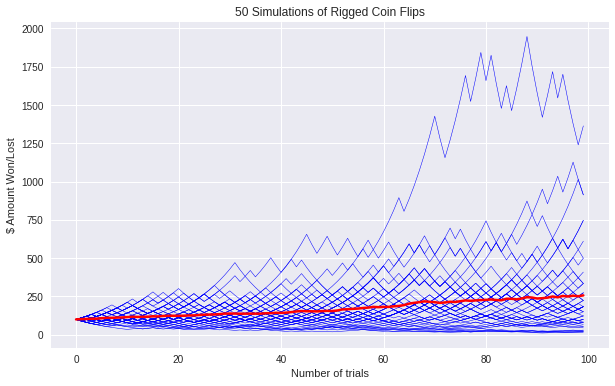

In [56]:
plt.figure(figsize=(10,6))
plt.plot(c_1, 'b', lw=0.5) #Plots all 50 series.
plt.plot(c_1.mean(axis=1), 'r', lw=2.5); #Plots the average over all 50 series.
plt.title('50 Simulations of Rigged Coin Flips');
plt.xlabel('Number of trials');
plt.ylabel('$ Amount Won/Lost');

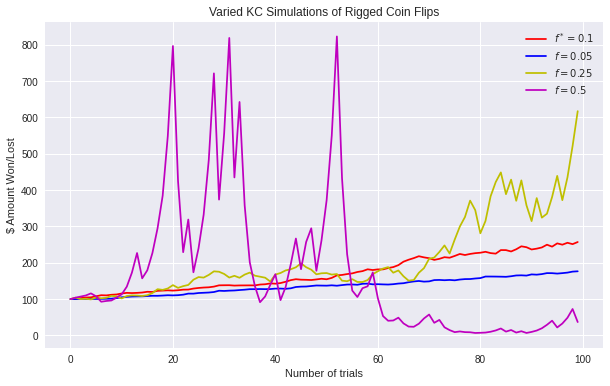

In [57]:
c_2 = run_simulation(0.05) #Simulation with f = 0.05.
c_3 = run_simulation(0.25) #Simulation with f = 0.25.
c_4 = run_simulation(0.5) #Simulation with f = 0.5.
plt.figure(figsize=(10, 6))
plt.plot(c_1.mean(axis=1), 'r', label='$f^*=0.1$')
plt.plot(c_2.mean(axis=1), 'b', label='$f=0.05$')
plt.plot(c_3.mean(axis=1), 'y', label='$f=0.25$')
plt.plot(c_4.mean(axis=1), 'm', label='$f=0.5$')
plt.legend(loc=0);
plt.title('Varied KC Simulations of Rigged Coin Flips');
plt.xlabel('Number of trials');
plt.ylabel('$ Amount Won/Lost');

In [58]:
from google.colab import files 
  
  
uploaded = files.upload()

Saving SPY Historical Data.csv to SPY Historical Data (1).csv


In [59]:
#Loading SPY data
data = pd.read_csv('SPY Historical Data.csv', index_col=0, parse_dates=True)
#Light Feature Engineering on Returns
data['Change %'] = data['Change %'].map(lambda x: x.rstrip('%')).astype(float) / 100
data.dropna(inplace=True)
data.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-09-01,352.60,350.22,352.64,349.26,55.00M,0.0094
2020-08-31,349.31,350.29,351.26,349.11,66.10M,-0.0036
2020-08-30,350.58,350.58,350.58,350.58,-,0.0000
2020-08-28,350.58,349.44,350.72,348.15,48.59M,0.0065
2020-08-27,348.33,348.36,349.89,346.54,58.03M,0.0022


In [60]:
mu = data['Change %'].mean() * 252 #Calculates the annualized return.
sigma = (data['Change %'].std() * 252 ** 0.5)  #Calculates the annualized volatility.
r = 0.0179 #1 year treasury rate
f = (mu - r) / sigma ** 2 #Calculates the optimal Kelly fraction to be invested in the strategy.
f

-11.74643708645502

Text(0, 0.5, '$ Return')

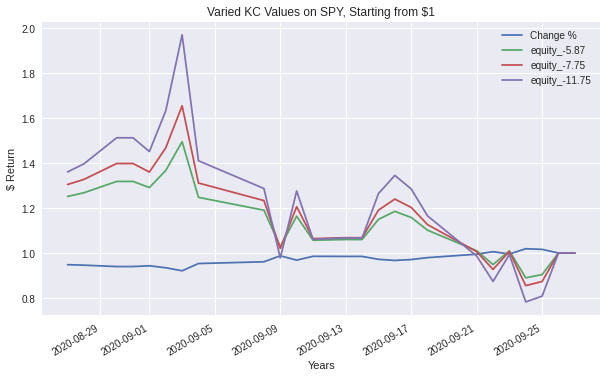

In [61]:
equs = [] # preallocating space for our simulations
def kelly_strategy(f):
    global equs
    equ = 'equity_{:.2f}'.format(f)
    equs.append(equ)
    cap = 'capital_{:.2f}'.format(f)
    data[equ] = 1  #Generates a new column for equity and sets the initial value to 1.
    data[cap] = data[equ] * f  #Generates a new column for capital and sets the initial value to 1·f∗.
    for i, t in enumerate(data.index[1:]):
        t_1 = data.index[i]  #Picks the right DatetimeIndex value for the previous values.
        data.loc[t, cap] = data[cap].loc[t_1] * math.exp(data['Change %'].loc[t])
        data.loc[t, equ] = data[cap].loc[t] - data[cap].loc[t_1] + data[equ].loc[t_1]
        data.loc[t, cap] = data[equ].loc[t] * f 

kelly_strategy(f * 0.5) # Values for 1/2 KC
kelly_strategy(f * 0.66) # Values for 2/3 KC
kelly_strategy(f) # Values for optimal KC
ax = data['Change %'].cumsum().apply(np.exp).plot(legend=True,figsize=(10, 6))         
data[equs].plot(ax=ax, legend=True);
plt.title('Varied KC Values on SPY, Starting from $1');
plt.xlabel('Years');
plt.ylabel('$ Return')

Ref:


1.   Finbox, Investing With Kelly (2018), https://www.valuewalk.com/2018/04/investing-with-the-kelly-criterion-model/
2.   J. Kuepper, Using the Kelly Criterion for Asset Allocation and Money Management (2019), https://www.investopedia.com/articles/trading/04/091504.asp
3. OSV, Apply the Kelly Criterion to Investing and Your Portfolio Sizing (2014), https://www.oldschoolvalue.com/blog/investing-strategy/kelly-criterion-investing-portfolio-sizing/
4. P. Lindmark, Investing with the Kelly Criterion (2007), https://www.gurufocus.com/news/4883/investing-with-the-kelly-criterion
5. Y. Hiplisch, Python for Finance: Mastering Data-Driven Finance (2018), O’Reilly Media https://amzn.to/2KuHPRG

6.  Investing.com, SPY 500 Historical Data, https://www.investing.com/etfs/spdr-s-p-500-historical-data
